In [1]:
from google.colab import drive
drive.mount("/drive")

Mounted at /drive


# **Import Libraries**

In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
%matplotlib inline
import seaborn as sns
import nltk
nltk.download('stopwords')
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **Import Dataset**

In [3]:
sms = pd.read_csv('/drive/My Drive/task1/Spam SMS Collection.csv', sep='\t', names=['label','message'])

In [4]:
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
sms['label'].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [6]:
sms['labels'] = sms['label'].map({'ham': 0, 'spam': 1})
sms.head()

,label,message,labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# **Visualise the Dataset**

In [7]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,labels,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


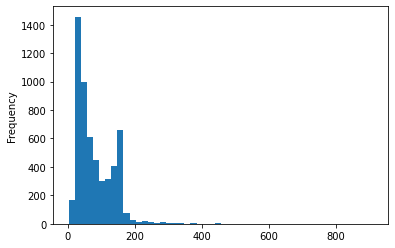

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sms['length'].plot(bins=50, kind='hist')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb6796f0a20>,
      dtype=object)

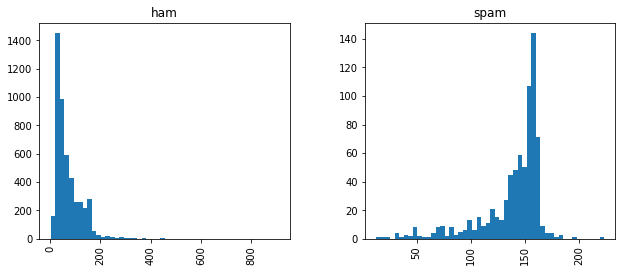

In [9]:
sms.hist(column='length', by='label', bins=50,figsize=(10,4))

In [7]:
sms.drop(['label'], axis = 1, inplace = True)
sms.head()

,message,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
print(sms.shape)

(5572, 2)


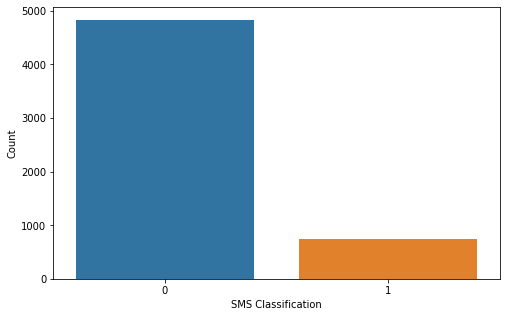

In [12]:
plt.figure(figsize=(8,5))
sns.countplot(x='labels', data=sms)
plt.xlabel('SMS Classification')
plt.ylabel('Count')
plt.show()

balance the dataset 

In [9]:
class_count_0, class_count_1 = sms['labels'].value_counts()

# Separate class
class_0 = sms[sms['labels'] == 0]
class_1 = sms[sms['labels'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (4825, 2)
class 1: (747, 2)


total class of 1 and 0:
 1    4825
0    4825
Name: labels, dtype: int64


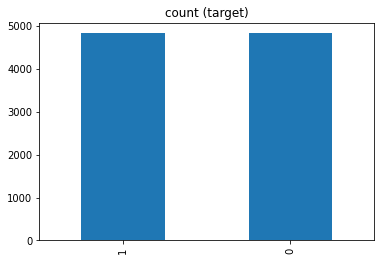

In [10]:
class_1_over = class_1.sample(class_count_0, replace=True)

test_over = pd.concat([class_1_over, class_0], axis=0)

print("total class of 1 and 0:\n",test_over['labels'].value_counts())# plot the count after under-sampeling
test_over['labels'].value_counts().plot(kind='bar', title='count (target)')

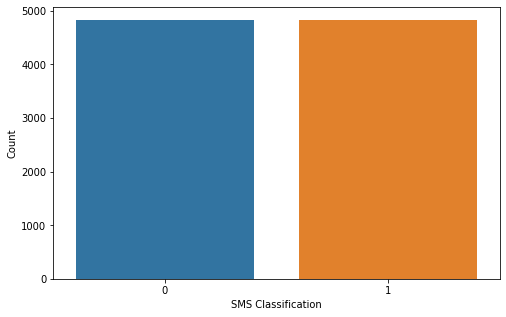

In [11]:
plt.figure(figsize=(8,5))
sns.countplot(x='labels', data=test_over)
plt.xlabel('SMS Classification')
plt.ylabel('Count')
plt.show()

In [26]:
'''class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and 0:\n",test_under['labels'].value_counts())# plot the count after under-sampeling
test_under['labels'].value_counts().plot(kind='bar', title='count (target)')
'''

'class_0_under = class_0.sample(class_count_1)\n\ntest_under = pd.concat([class_0_under, class_1], axis=0)\n\nprint("total class of 1 and 0:\n",test_under[\'labels\'].value_counts())# plot the count after under-sampeling\ntest_under[\'labels\'].value_counts().plot(kind=\'bar\', title=\'count (target)\')\n'

In [12]:
test_over.shape

(9650, 2)

In [13]:
test_over.head()

,message,labels
3646,wamma get laid?want real doggin locations sent...,1
1072,URGENT! We are trying to contact U. Todays dra...,1
3860,Win the newest Harry Potter and the Order of ...,1
487,FREE MESSAGE Activate your 500 FREE Text Messa...,1
368,Here is your discount code RP176781. To stop f...,1


In [14]:
test_over.sort_index(axis = 0) 

,message,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1
5568,Will ü b going to esplanade fr home?,0
5569,"Pity, * was in mood for that. So...any other s...",0
5570,The guy did some bitching but I acted like i'd...,0


In [15]:
test_over.reset_index(drop=True, inplace=True)

In [16]:
test_over.shape

(9650, 2)

# **Data Cleaning**

In [17]:
corpus = []
ps = PorterStemmer()

for i in range(0,test_over.shape[0]):
    message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=test_over.message[i]) #Cleaning special character from the message
    message = message.lower() #Converting the entire message into lower case
    words = message.split() # Tokenizing the review by words
    words = [word for word in words if word not in set(stopwords.words('english'))] #Removing the stop words
    words = [ps.stem(word) for word in words] #Stemming the words
    message = ' '.join(words) #Joining the stemmed words
    corpus.append(message) #Building a corpus of messages

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000)
X = cv.fit_transform(corpus).toarray()

In [62]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(max_features=5000)

X=tfidf.fit_transform(corpus).toarray()
'''

'\nfrom sklearn.feature_extraction.text import TfidfVectorizer\ntfidf=TfidfVectorizer(max_features=5000)\n\nX=tfidf.fit_transform(corpus).toarray()\n'

In [45]:
y = test_over['labels'].values

In [46]:
X.shape

(9650, 5000)

In [48]:
y.shape


(9650,)

# **split the dataset into training and test set**

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# **Building the MultinomialNB model**

In [50]:
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# **Evaluating the model**

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

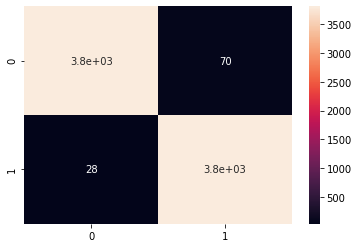

In [52]:
y_predict_train = NB_classifier.predict(X_train)
y_predict_train
cm = confusion_matrix(y_train, y_predict_train)
sns.heatmap(cm, annot=True)

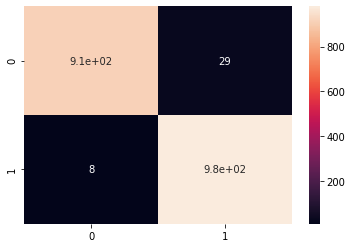

In [53]:
# Predicting the Test set results
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [54]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       942
           1       0.97      0.99      0.98       988

    accuracy                           0.98      1930
   macro avg       0.98      0.98      0.98      1930
weighted avg       0.98      0.98      0.98      1930



In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(y_test, y_predict_test)))
print('Precision score: {}'.format(precision_score(y_test, y_predict_test)))
print('Recall score: {}'.format(recall_score(y_test, y_predict_test)))
print('F1 score: {}'.format(f1_score(y_test, y_predict_test)))

Accuracy score: 0.9808290155440414
Precision score: 0.9712586719524281
Recall score: 0.9919028340080972
F1 score: 0.9814722083124686


# **svc**

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       942
           1       0.99      1.00      1.00       988

    accuracy                           1.00      1930
   macro avg       1.00      1.00      1.00      1930
weighted avg       1.00      1.00      1.00      1930



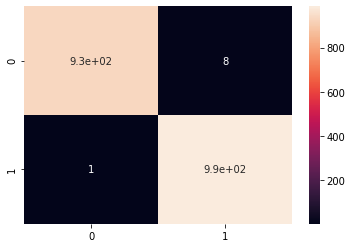

In [56]:
from sklearn.svm import SVC
model=SVC(kernel='linear')
model.fit(X_train, y_train)
# Predicting the Test set results
y_predict_test = model.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)
print(classification_report(y_test, y_predict_test))

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(y_test, y_predict_test)))
print('Precision score: {}'.format(precision_score(y_test, y_predict_test)))
print('Recall score: {}'.format(recall_score(y_test, y_predict_test)))
print('F1 score: {}'.format(f1_score(y_test, y_predict_test)))

Accuracy score: 0.9953367875647668
Precision score: 0.9919597989949749
Recall score: 0.9989878542510121
F1 score: 0.9954614220877458


# **LogisticRegression**

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       942
           1       0.99      0.99      0.99       988

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930



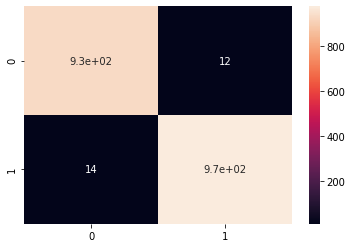

In [58]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train, y_train)
# Predicting the Test set results
y_predict_test = model.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)
print(classification_report(y_test, y_predict_test))

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(y_test, y_predict_test)))
print('Precision score: {}'.format(precision_score(y_test, y_predict_test)))
print('Recall score: {}'.format(recall_score(y_test, y_predict_test)))
print('F1 score: {}'.format(f1_score(y_test, y_predict_test)))

Accuracy score: 0.9911917098445596
Precision score: 0.9868554095045501
Recall score: 0.9959183673469387
F1 score: 0.9913661757237175


# **Decision Tree**

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       942
           1       0.96      0.99      0.98       988

    accuracy                           0.97      1930
   macro avg       0.98      0.97      0.97      1930
weighted avg       0.98      0.97      0.97      1930



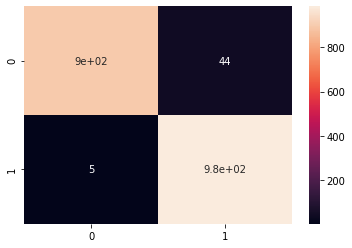

In [59]:
from sklearn.tree import DecisionTreeClassifier
model=DecisionTreeClassifier()
model.fit(X_train, y_train)
# Predicting the Test set results
y_predict_test = model.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)
print(classification_report(y_test, y_predict_test))


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy score: {}'.format(accuracy_score(y_test, y_predict_test)))
print('Precision score: {}'.format(precision_score(y_test, y_predict_test)))
print('Recall score: {}'.format(recall_score(y_test, y_predict_test)))
print('F1 score: {}'.format(f1_score(y_test, y_predict_test)))

Accuracy score: 0.9746113989637306
Precision score: 0.9571567672833495
Recall score: 0.9949392712550608
F1 score: 0.975682382133995


# **Testing**

In [61]:
testing_sample = [' win price lottry!!!!!', "Hello, I am Ryan, I would like to book a hotel in SF by January 24th"]
testing_sample_countvectorizer = cv.transform(testing_sample)
test_predict = NB_classifier.predict(testing_sample_countvectorizer)
test_predict

array([1, 0])